<a href="https://colab.research.google.com/github/akvo/cdi-scripts/blob/feature%2F17-scripts-update-2024-11-27/source%20/scripts/eSwatini_CDI_raster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install geopandas rasterio rasterstats numpy folium rioxarray

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 11.6 MB/s eta 0:00:00


In [3]:
import rasterio
import numpy as np
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import rioxarray as rxr
from branca.colormap import StepColormap
from rasterio import open as rio_open
from rasterstats import zonal_stats

In [4]:
#file_path = "/content/drive/MyDrive/Eswatini Drought Monitoring Project - Iwan/CDI Raster"
input_file = "eswatini_sample_CDI.tif"
output_percentile_file = "eswatini_percentile.tif"
nodata_value = -9999
percentile = 50
geojson_file = "eswatini.geojson"

In [5]:
# Read the raster data
with rasterio.open(input_file) as src:
    raster_stack = src.read()  # Read all bands into a 3D array (bands, rows, columns)
    profile = src.profile  # Get raster metadata
    transform = src.transform  # Original raster's transform
    crs = src.crs

# Mask NoData values
print("Data Shape:", raster_stack.shape)
mask = raster_stack == nodata_value
raster_array=np.where(mask, np.nan, raster_stack)
# raster_array


Data Shape: (1, 31, 26)


In [6]:
flat_raster = raster_array.flatten()
ranks = np.argsort(np.argsort(flat_raster))
percentiles = (ranks / (len(flat_raster) - 1)) * 100
percentile_raster = percentiles.reshape(raster_array.shape)

In [7]:
with rasterio.open(
    output_percentile_file,
    'w',
    driver='GTiff',
    height=percentile_raster.shape[1],
    width=percentile_raster.shape[2],
    # count=percentile_raster.shape[0],  # Number of bands
    count=1,  # One band (single-band raster)
    dtype=percentile_raster.dtype,  # Data type of the raster
    crs=crs,  # Use the same CRS as the original raster
    transform=transform

) as dst:
    dst.write(percentile_raster[0, :, :], 1)

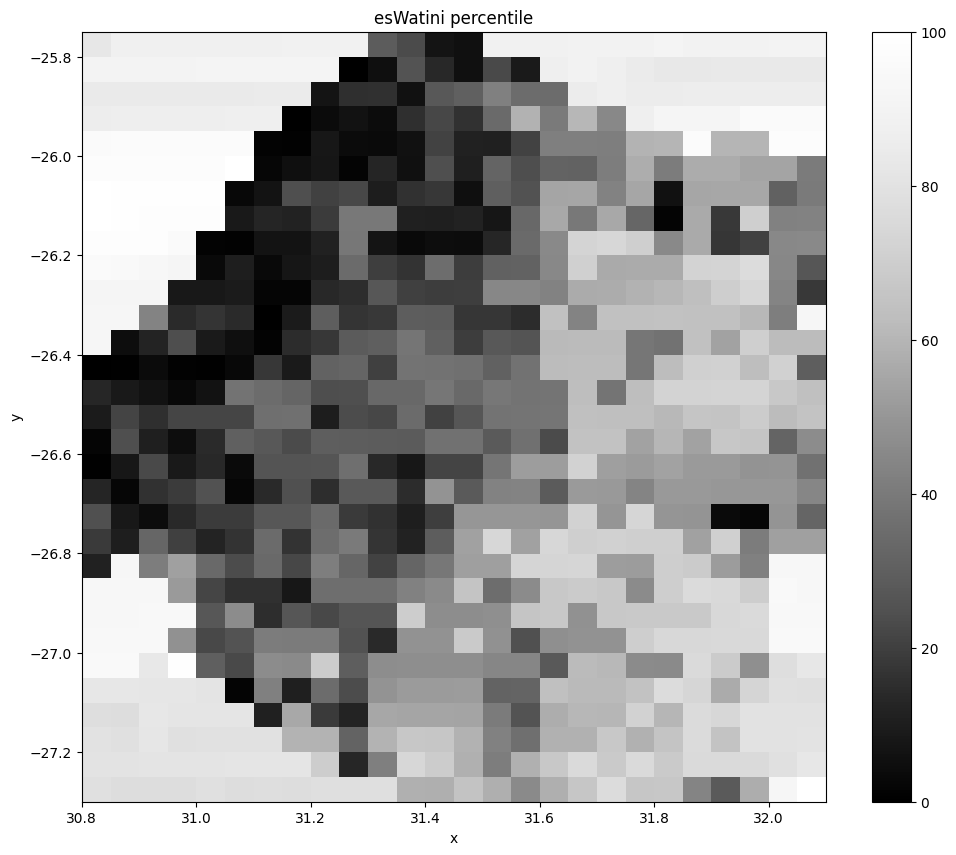

In [8]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 10)
rds = rxr.open_rasterio(output_percentile_file)
band = rds.sel(band=1)
band.plot.imshow(ax=ax, cmap='Greys_r')
ax.set_title('esWatini percentile')
plt.show()

In [11]:
stats_cdi=zonal_stats(
    geojson_file,          # GeoJSON or GeoDataFrame
    input_file,           # Input raster file
    stats=["median"],      # Statistics to calculate (e.g., 'median')
    nodata=np.nan,         # Ignore NoData values in the raster
    geojson_out=True       # Include GeoJSON data in the output
)
stats_cdi_gdf=gpd.GeoDataFrame.from_features(stats_cdi)
stats_cdi_gdf[["geometry", "median"]]

,geometry,median
0,"MULTIPOLYGON (((30.99733 -26.62526, 30.98134 -...",0.58
1,"MULTIPOLYGON (((31.82491 -26.75235, 31.82542 -...",0.74
2,"MULTIPOLYGON (((31.39154 -25.78124, 31.39133 -...",0.46
3,"MULTIPOLYGON (((31.97766 -26.46764, 31.98457 -...",0.72
4,"MULTIPOLYGON (((31.66517 -25.94556, 31.66414 -...",0.70
5,"MULTIPOLYGON (((31.54774 -26.02699, 31.54748 -...",0.56
6,"MULTIPOLYGON (((31.3203 -27.08863, 31.31878 -2...",0.64
7,"MULTIPOLYGON (((31.15856 -26.27106, 31.16669 -...",0.58
8,"MULTIPOLYGON (((31.50425 -26.89926, 31.50481 -...",0.74
9,"MULTIPOLYGON (((31.38083 -25.80742, 31.38085 -...",0.56


In [15]:
pip install leafmap mapclassify

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 3.6 MB/s eta 0:00:00


In [16]:
# gdf_cdi = gpd.GeoDataFrame.from_features(features_info)
# gdf['Mean_Rainfall'] = gdf['rain'].apply(lambda x: pd.Series(x).mean())
# gdfFiltered=gdf
# gdfFiltered=adjustPolupation(gdfFiltered)
# gdfFiltered = gdfFiltered.dropna(subset=[attr])
# gdfFiltered = gdfFiltered[gdfFiltered[attr].apply(lambda x: isinstance(x, (int, float)))]
# gdfFiltered=gdf[gdf[attr]>1]
# gdf["density"]=round(gdf["population"]/gdf["area"])
import leafmap
attr="median"
m_cdi = leafmap.Map()
# m.add_data(
#     gdfFiltered, column="population2000", scheme="JenksCaspall",  layer_name="population2000" ,legend_title="population2000", k=5 , colors=['#ffffcc','#a1dab4','#41b6c4','#2c7fb8','#253494']
# )
m_cdi.add_data(
    stats_cdi_gdf, column=attr, scheme="FisherJenks",  layer_name=attr,legend_title=attr ,k=5, colors=['#ffffd4','#fed98e','#fe9929','#d95f0e','#993404']
)
m_cdi

ValueError: Length of values (52) does not match length of index (53)

In [78]:
# Calculate zonal statistics
stats = zonal_stats(
    geojson_file,          # GeoJSON or GeoDataFrame
    output_percentile_file,           # Input raster file
    stats=["median"],      # Statistics to calculate (e.g., 'median')
    nodata=np.nan,         # Ignore NoData values in the raster
    geojson_out=True       # Include GeoJSON data in the output
)

# Convert the result to a GeoDataFrame
stats_gdf = gpd.GeoDataFrame.from_features(stats)

In [79]:
# Load Raster
with rasterio.open(input_file) as src:
    print("Raster CRS:", src.crs)
# Ensure CRS is set before saving
stats_gdf.geometry.set_crs(src.crs, inplace=True)
# Display the resulting GeoDataFrame with the calculated 'median' field
# stats_gdf[["geometry", "median"]]

Raster CRS: EPSG:4326


,geometry
0,"MULTIPOLYGON (((30.99733 -26.62526, 30.98134 -..."
1,"MULTIPOLYGON (((31.82491 -26.75235, 31.82542 -..."
2,"MULTIPOLYGON (((31.39154 -25.78124, 31.39133 -..."
3,"MULTIPOLYGON (((31.97766 -26.46764, 31.98457 -..."
4,"MULTIPOLYGON (((31.66517 -25.94556, 31.66414 -..."
5,"MULTIPOLYGON (((31.54774 -26.02699, 31.54748 -..."
6,"MULTIPOLYGON (((31.3203 -27.08863, 31.31878 -2..."
7,"MULTIPOLYGON (((31.15856 -26.27106, 31.16669 -..."
8,"MULTIPOLYGON (((31.50425 -26.89926, 31.50481 -..."
9,"MULTIPOLYGON (((31.38083 -25.80742, 31.38085 -..."


In [80]:
# Save to a new GeoJSON file
geojson_data = "eswatini_with_median.geojson"
stats_gdf.to_file(geojson_data, driver="GeoJSON")

print(f"Output saved to {geojson_data}")

Output saved to eswatini_with_median.geojson


In [81]:
# Define a function to map median values to colors
def get_color(value):
    if not value:
      return "#FFFFFF"
    if value <= 2:
        return "#730000"
    elif value <= 5:
        return "#E60000"
    elif value <= 10:
        return "#FFAA00"
    elif value <= 20:
        return "#FCD37F"
    elif value <= 30:
        return "#FFFF00"
    else:
        return "#FFFFFF"

# Create the map
lon, lat = 31.4659, -26.5225
zoom_start = 8
m = folium.Map(location=[lat, lon], tiles="OpenStreetMap", zoom_start=zoom_start)

# Add GeoJSON layer with styling
folium.GeoJson(
    geojson_data,
    name="choropleth",
    style_function=lambda feature: {
        "fillColor": get_color(feature["properties"]["median"]),
        "color": "black",
        "weight": 0.5,
        "fillOpacity": 0.7,
    },
    highlight_function=lambda feature: {
        "weight": 3,
        "color": "blue",
        "fillOpacity": 0.9,
    },
    tooltip=folium.GeoJsonTooltip(
        fields=["name", "median"],
        aliases=["Region:", "Median:"],
        localize=True,
    ),
).add_to(m)

# Add a legend manually
legend_html = """
<div style="position: fixed;
            bottom: 50px; left: 50px; width: 200px; height: 250px;
            background-color: white; z-index:9999; font-size:14px;
            border:2px solid grey; padding: 10px;">
    <b>Median Value Legend</b><br/><br/>
    <span style="display: flex;gap: 4px; align-items: center;margin-bottom: 4px;"><i style="background: #730000; width: 20px; height: 20px; display: inline-block;"></i><i>Exceptional Drought</i></span>
    <span style="display: flex;gap: 4px; align-items: center;margin-bottom: 4px;"><i style="background: #E60000; width: 20px; height: 20px; display: inline-block;"></i><i>Extreme Drought</i></span>
    <span style="display: flex;gap: 4px; align-items: center;margin-bottom: 4px;"><i style="background: #FFAA00; width: 20px; height: 20px; display: inline-block;"></i><i>Severe Drought</i></span>
    <span style="display: flex;gap: 4px; align-items: center;margin-bottom: 4px;"><i style="background: #FCD37F; width: 20px; height: 20px; display: inline-block;"></i><i>Moderate Drought</i></span>
    <span style="display: flex;gap: 4px; align-items: center;margin-bottom: 4px;"><i style="background: #FFFF00; width: 20px; height: 20px; display: inline-block;"></i><i>Abnormally Dry</i></span>
    <span style="display: flex;gap: 4px; align-items: center;margin-bottom: 4px;"><i style="background: #FFFFFF; width: 20px; height: 20px; display: inline-block;border: 1px solid #000;"></i><i>Normal or wet conditions</i></span>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# Save or display the map
m.save("choropleth_map.html")

m